In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# 1. Импорт данных, генерация признаков

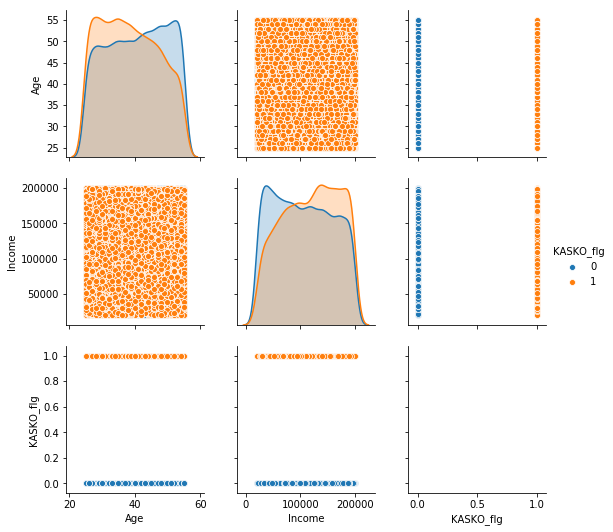

In [2]:
df_train = pd.read_excel('Test case - Regression.xlsx').drop('Unnamed: 0', axis =1)

#посмотрим на данные
sns.pairplot(df_train, hue='KASKO_flg')

In [3]:
# генерация признаков

def age_format(age):
    if 18 <= age <= 24:
        return 1
    elif 25 <= age <= 34:
        return 2
    elif 35 <= age <= 44:
        return 3
    elif 45 <= age <= 54:
        return 4
    elif age >= 55:
        return 5
    else: 
        return 0

df_train.loc[:,  ['Gender']] = df_train.loc[:,  ['Gender']].replace({'Female':1,'Male':0})
df_train['Gender'].astype(int)
df_train = pd.get_dummies(df_train, columns=['Gender'])
df_train['Age'] = df_train['Age'].map(lambda x: age_format(x) )
df_train = pd.get_dummies(df_train, columns=['Age'])

df_train =df_train[['Gender_0', 'Gender_1', 'Age_2', 'Age_3',
       'Age_4', 'Age_5', 'Income', 'KASKO_flg']]

In [4]:
df_train.head()

,Gender_0,Gender_1,Age_2,Age_3,Age_4,Age_5,Income,KASKO_flg
0,0,1,0,0,1,0,30000,0
1,1,0,0,1,0,0,135000,0
2,1,0,0,1,0,0,70000,0
3,0,1,1,0,0,0,127000,0
4,1,0,0,0,1,0,125000,0


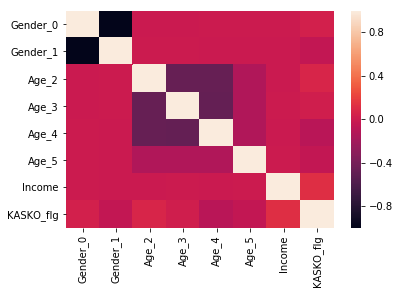

In [5]:
# проверка корреляции с признаками
sns.heatmap(df_train.corr())

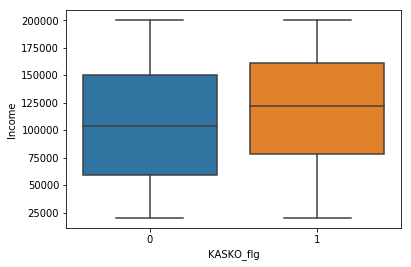

In [6]:
sns.boxplot(x='KASKO_flg', y='Income', data=df_train);

# 2. Делим на обучающую и тестовую выборку

In [7]:
from sklearn.model_selection import train_test_split

df_X = df_train.drop('KASKO_flg', axis =1).values
df_y = df_train['KASKO_flg'].values.reshape(-1,1)

X_train, X_test, y_train, y = train_test_split(df_X, df_y, test_size=0.33, random_state=42)
print('X_train ', X_train.shape)
print('X_test ',X_test.shape)

X_train  (26800, 7)
X_test  (13200, 7)


# 3. Строим модель Логистической регрессии и ее предсказание 

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

model = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression())])

model.fit(X_train, y_train)
predict = model.predict(X_test)
predict_proba = model.predict_proba(X_test)

# print('model metrics:\n')
# print(classification_report(y, predict))


from sklearn.metrics import roc_auc_score, roc_curve

# валидация модели
cross = cross_val_score(model,df_X,df_y,scoring='roc_auc', cv=10)
roc_auc = (sum(cross)) / float(len(cross))
gini = 2*roc_auc-1

print('cross_val_score GINI\t{:.4f}'.format( gini ) )
print('cross_val_score ROC_AUC\t{:.4f}'.format( roc_auc ) )

cross_val_score GINI	0.2084
cross_val_score ROC_AUC	0.6042


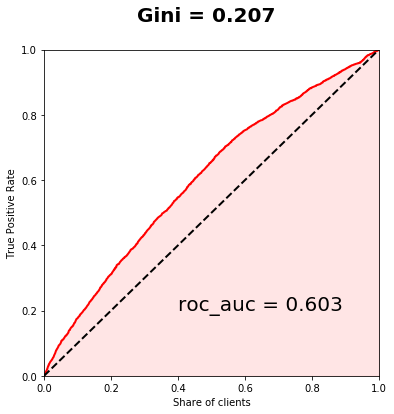

In [9]:
# визуализация метрики
# формулы расчета Gini с доказательством взяты отсюда https://habr.com/company/ods/blog/350440/

actual = y
predict = predict_proba[:, 1]

data = zip(actual, predict)
sorted_data = sorted(data, key=lambda d: d[1], reverse=True)
sorted_actual = [d[0] for d in sorted_data]

cumulative_actual = np.cumsum(sorted_actual) / sum(actual)
cumulative_index = np.arange(1, len(cumulative_actual)+1) / len(predict)
cumulative_actual_perfect = np.cumsum(sorted(actual, reverse=True)) / sum(actual)

aucroc = roc_auc_score(actual, predict)
gini = 2*roc_auc_score(actual, predict)-1
fpr, tpr, t = roc_curve(actual, predict)
x_values = [0] + list(cumulative_index)
y_values = [0] + list(cumulative_actual)
y_values_perfect = [0] + list(cumulative_actual_perfect)

fig, ax = plt.subplots(nrows=1,ncols=1, sharey=True, figsize=(6, 6))
fig.suptitle('Gini = {:0.3f}'.format(gini),fontsize = 20, fontweight='bold')

plt.plot([0]+fpr.tolist(), [0]+tpr.tolist(), lw = 2, color = 'red')
plt.fill_between([0]+fpr.tolist(), [0]+tpr.tolist(), color = 'red', alpha=0.1)
plt.text(0.4,0.2,'roc_auc = {:0.3f}'.format(aucroc),fontsize = 20)

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
plt.xlabel('Share of clients')
plt.ylabel('True Positive Rate')
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.show();

Вывод: оценка качества модели зависит от ваших установленных метрик в компании.


Для улучшения качества модели - требуются дополнительные признаки (геолокация и профили клиентов, уровень доходов, наличие недвижимости и автомобилей, состав семьи, банковские транзакции клиентов и т.п.)

# Дополнительно: метод ближайших соседей

CPU times: user 6min, sys: 6.91 s, total: 6min 7s
Wall time: 5min 42s


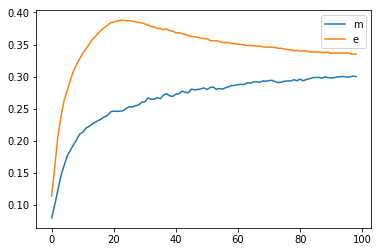

In [10]:
%%time

from sklearn.neighbors import KNeighborsClassifier

# подберем оптимальное кол-во ближайших соседей модели

scores_test = []
scores_train = []

for k in range(1, 100):
    
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=k))
    ])
    
    model.fit(X_train, y_train, )

    y_hat_test = model.predict_proba(X_test)
    gini = 2*roc_auc_score(y, y_hat_test[:, 1]) -1
    scores_test.append( gini )
    
    y_hat_train = model.predict_proba(X_train)
    gini = 2*roc_auc_score(y_train, y_hat_train[:, 1]) -1
    scores_train.append( gini )
    
plt.plot(scores_test, label='test')
plt.plot(scores_train, label='train')
plt.legend('metric Gini')    

Построение лучшей модели

In [11]:
%%time

#weights - они будут все равнозначны 
#metric - выбрать или придумать свою

n = 23

knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=n))
])

knn.fit(X_train, y_train)
predict = model.predict(X_test)
predict_proba = model.predict_proba(X_test)

# валидация модели
cross = cross_val_score(model,df_X,df_y,scoring='roc_auc', cv=10)
roc_auc = float(sum(cross)) / float(len(cross))
gini = 2*roc_auc-1

print('cross_val_score GINI\t{:.4f}\n'.format( gini ) )

cross_val_score GINI	0.2942

CPU times: user 26.3 s, sys: 404 ms, total: 26.7 s
Wall time: 25.4 s


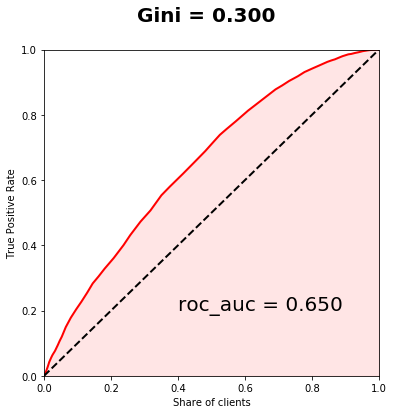

In [12]:
# визуализация метрики
# формулы расчета Gini с доказательством взяты отсюда https://habr.com/company/ods/blog/350440/

actual = y
predict = predict_proba[:, 1]

data = zip(actual, predict)
sorted_data = sorted(data, key=lambda d: d[1], reverse=True)
sorted_actual = [d[0] for d in sorted_data]

cumulative_actual = np.cumsum(sorted_actual) / sum(actual)
cumulative_index = np.arange(1, len(cumulative_actual)+1) / len(predict)
cumulative_actual_perfect = np.cumsum(sorted(actual, reverse=True)) / sum(actual)

aucroc = roc_auc_score(actual, predict)
gini = 2*roc_auc_score(actual, predict)-1
fpr, tpr, t = roc_curve(actual, predict)
x_values = [0] + list(cumulative_index)
y_values = [0] + list(cumulative_actual)
y_values_perfect = [0] + list(cumulative_actual_perfect)

fig, ax = plt.subplots(nrows=1,ncols=1, sharey=True, figsize=(6, 6))
fig.suptitle('Gini = {:0.3f}'.format(gini),fontsize = 20, fontweight='bold')

plt.plot([0]+fpr.tolist(), [0]+tpr.tolist(), lw = 2, color = 'red')
plt.fill_between([0]+fpr.tolist(), [0]+tpr.tolist(), color = 'red', alpha=0.1)
plt.text(0.4,0.2,'roc_auc = {:0.3f}'.format(aucroc),fontsize = 20)

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
plt.xlabel('Share of clients')
plt.ylabel('True Positive Rate')
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.show();

Добавим вероятность target=1 в исходный массив и отсортируем по данной вероятности:

In [13]:
df_train = pd.read_excel('Test case - Regression.xlsx').drop('Unnamed: 0', axis =1).reset_index().merge(
    (pd.DataFrame(model.predict_proba(df_X))).reset_index(),
    on = 'index'
).sort_values(1, ascending = False)

df_train.head(50)

,index,Gender,Age,Income,KASKO_flg,0,1
22751,22751,Male,27,115000,1,0.333333,0.666667
35113,35113,Male,34,115000,0,0.333333,0.666667
38088,38088,Male,31,115000,1,0.333333,0.666667
17225,17225,Male,32,115000,1,0.333333,0.666667
2605,2605,Male,34,115000,0,0.333333,0.666667
5303,5303,Male,32,115000,0,0.333333,0.666667
34880,34880,Male,28,115000,0,0.333333,0.666667
17426,17426,Male,29,115000,0,0.333333,0.666667
38697,38697,Male,27,115000,1,0.333333,0.666667
27283,27283,Male,30,115000,1,0.333333,0.666667
